# CARL Bandits

Using an extension of $\alpha_{Y'}$ to transfer $Q$.

## Setup

Let us start by importing a couple of generic libraries.

In [1]:
import os
os.chdir(os.path.abspath(os.path.pardir))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import ot
from tqdm import tqdm

from src.SCMMappings import Abstraction
from src.measuring import ICEvaluator
from src.examples import smokingmodels as sm
import src.evaluationsets as esets

import src.bandit_envs as BE
import src.bandit_agents as BA
import CARLa_trials as CTr
import CARLa_plots as Cplt
import CARLa_abserr as Cae

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
np.random.seed(0)

## Model setup

In [4]:
from src.CBN import CausalBayesianNetwork as CBN
from pgmpy.factors.discrete import TabularCPD as cpd

In [5]:
U = 'U'; X='X'; Y='Y'; Z='Z'
M0 = CBN([(U,X),(U,Y),(X,Y),(Z,X)])

cpdU = cpd(variable=U,
          variable_card=2,
          values=np.array([[.2],[.8]]),
          evidence=None,
          evidence_card=None)
cpdZ = cpd(variable=Z,
          variable_card=2,
          values=np.array([[.1],[.9]]),
          evidence=None,
          evidence_card=None)
cpdX = cpd(variable=X,
          variable_card=2,
          values=np.array([[1,0,0,1.],[0,1,1,0]]),
          evidence=[U,Z],
          evidence_card=[2,2])
cpdY = cpd(variable=Y,
          variable_card=2,
          values=np.array([[.1,.9,.5,.1],[.9,.1,.5,.9]]),
          evidence=[U,X],
          evidence_card=[2,2])

M0.add_cpds(cpdU,cpdZ,cpdX,cpdY)
M0.check_model()

True

In [6]:
U = 'U_'; X='X_'; Y='Y_'
M1 = CBN([(U,Y),(X,Y)])

cpdU = cpd(variable=U,
          variable_card=2,
          values=np.array([[.2],[.8]]),
          evidence=None,
          evidence_card=None)
cpdX = cpd(variable=X,
          variable_card=2,
          values=np.array([[.5],[.5]]),
          evidence=None,
          evidence_card=None)
cpdY = cpd(variable=Y,
          variable_card=2,
          values=np.array([[.1,.9,.5,.1],[.9,.1,.5,.9]]),
          evidence=[U,X],
          evidence_card=[2,2])

M1.add_cpds(cpdU,cpdX,cpdY)
M1.check_model()

True

In [7]:
R = ['U','X','Y']
a = {'U': 'U_',
    'X': 'X_',
    'Y': 'Y_'}
alphas = {'U_': np.eye(2),
          'X_': np.eye(2),
          'Y_': np.eye(2)}

In [8]:
map_rewards = {i:np.argmax(alphas['Y_'][:,i]) for i in range(alphas['Y_'].shape[1])}
    
ydomain0 = lambda x:x
ydomain1 = lambda x:x
map_ydomains = {ydomain0(i):ydomain1(j) for i,j in map_rewards.items()}

actions0=[{'X':0}, {'X':1}]
actions1=[{'X_':0}, {'X_':1}]
map_actions = {0: 0, 1: 1}

In [9]:
def metricW2(p,q):
    Dy1 = np.array([ydomain0(i) for i in map_rewards.values()])
    
    if p.ndim == 1:
        return ot.wasserstein_1d(Dy1,Dy1,p,q,p=2)
    else:
        ws = []
        for i in range(p.shape[1]):
            w = ot.wasserstein_1d(Dy0,Dy1,p[:,i],q[:,i],p=2)
            ws.append(w)
        return ws

In [10]:
Ab = Abstraction(M0,M1,R,a,alphas)
Ae = ICEvaluator(Ab,metric=metricW2)
J = esets.get_causal_sets_in_M0_with_directed_path_in_M1_and_M0(Ab.M0,Ab.M1,Ab.a)
Ae.compute_overall_error(J)

0.32000000000000006

## Experiment settings

In [11]:
params_to_save_start = set(dir())
simulname = 'simul_4_2'

n_trials = 20
n_steps = 500

## CAMAB settings

### Bandits setting

In [12]:
B0 = BE.SCMEnv(scm=Ab.M0, actions=actions0, target='Y', ydomain=ydomain0)
B1 = BE.SCMEnv(scm=Ab.M1, actions=actions1, target='Y_', ydomain=ydomain1)

### Learning setting

In [13]:
bandits = [B1,B0,B1,B1,B1,B1]

labels = ['M1: transfer', 'M0: ucb', 'M1: ucb', 'M1: transfer-optimum', 'M1: imitation', 'M1: Qextension']
trainalg = ['ucb_bounds', 'ucb', 'ucb', 'transfer-optimum', 'imitation', 'transfer-expval']
params = {}

# Alg params
params['Qinit'] = [BA.initialize_Q_ones,BA.initialize_Q_ones,BA.initialize_Q_ones,None,BA.initialize_Q_ones,None]
params['Qtransferstep'] = [None,None,None,None,None,-1]
params['abserr'] = [None,None,None,None,None,Ae.compute_overall_error(J)]
params['delta'] = [None,None,None,None,None,0.01]

# UCB params
params['c'] = [1.0] * len(labels)

## Statistics settings

In [14]:
agents = [[] for _ in range(len(labels))]

params_to_save = set(dir()) - params_to_save_start
simulparams = [s for s in params_to_save if s[0]!='_']

# Transfer Training

In [15]:
lbounds = [0.48,0.72]
hbounds = [0.6,0.82]

In [16]:
bounds = [lbounds,hbounds]

In [17]:
params['bounds'] = [bounds,None,None,None,None,None]

In [18]:
for t in tqdm(range(n_trials)):
    ag0 = CTr.run_trial(bandits[0],n_steps,trainalg[0],
                        {k: params[k][0] for k in params.keys()},
                        map_actions,map_rewards,map_ydomains)
    agents[0].append(ag0)

  0%|                                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:182: RuntimeWarning: divide by zero encountered in log
  U = self.Q + self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:182: RuntimeWarning: invalid value encountered in sqrt
  U = self.Q + self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter )
  5%|████▉                                                                                              | 1/20 [00:02<00:45,  2.40s/it]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:182: RuntimeWarning: divide by zero encountered in log
  U = self.Q + self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:18

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 15/20 [00:59<00:21,  4.35s/it]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:182: RuntimeWarning: divide by zero encountered in log
  U = self.Q + self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:182: RuntimeWarning: invalid value encountered in sqrt
  U = self.Q + self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter )
 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 16/20 [01:03<00:17,  4.41s/it]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:182: RuntimeWarning: divide by zero encountered in log
  U = self.Q + self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:18

# Abstraction Training

In [19]:
for t in tqdm(range(n_trials)):
    ag1 = CTr.run_trial(bandits[1],n_steps,trainalg[1],
                        {k: params[k][1] for k in params.keys()},
                        map_actions,map_rewards,map_ydomains)
    agents[1].append(ag1)
    
    for i in range(2,len(labels)):
        ag = CTr.run_trial(bandits[i],n_steps,trainalg[i],
                           {k: params[k][i] for k in params.keys()},
                            map_actions,map_rewards,map_ydomains,base_bandit=ag1)
        agents[i].append(ag)
    
    

  0%|                                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in sqrt
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in divide
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits

 20%|███████████████████▊                                                                               | 4/20 [01:42<07:05, 26.61s/it]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in sqrt
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in divide
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits

 40%|███████████████████████████████████████▌                                                           | 8/20 [03:30<05:14, 26.22s/it]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in sqrt
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in divide
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits

 60%|██████████████████████████████████████████████████████████▊                                       | 12/20 [05:06<03:15, 24.44s/it]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in sqrt
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in divide
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits

 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 16/20 [06:41<01:36, 24.03s/it]C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in sqrt
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: invalid value encountered in divide
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits\scratchbook\CausalAbstraction\src\bandit_agents.py:146: RuntimeWarning: divide by zero encountered in log
  U = self.c * np.sqrt( np.log(np.sum(self.action_counter)) / self.action_counter  )
C:\Users\admin\gits

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:18<00:00, 24.90s/it]


# Persistence

In [20]:
stats = {simulparams[i]: eval(simulparams[i]) for i in range(len(simulparams))}

# Evaluation of the results

In [21]:
from collections import OrderedDict

linestyles = OrderedDict(
    [('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

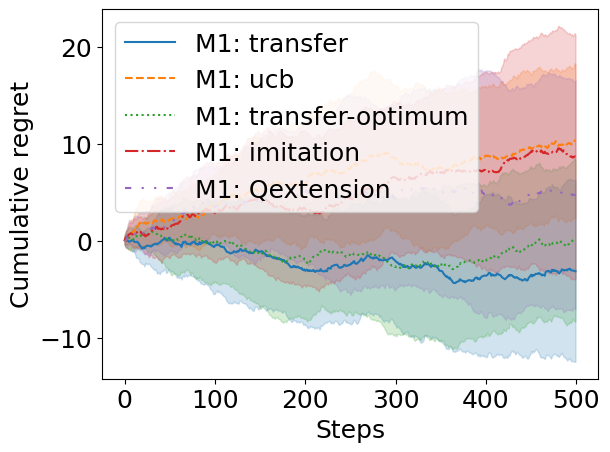

In [22]:
style = ['-','--',':','-.',linestyles['dashdotdotted']]
for n,i in enumerate([0,2,3,4,5]):
    cumregrets = [agents[i][j].get_cumulative_regret() for j in range(len(agents[i]))]
    avg = np.mean(cumregrets,axis=0)
    std = np.std(cumregrets,axis=0)

    plt.plot(np.arange(n_steps),avg,label=labels[i],color="C{}".format(n),linestyle=style[n])
    plt.fill_between(np.arange(n_steps),avg+std,avg-std, color='C{}'.format(n), alpha=0.2)
    plt.xlabel('Steps')
    plt.ylabel('Cumulative regret')
    plt.legend()

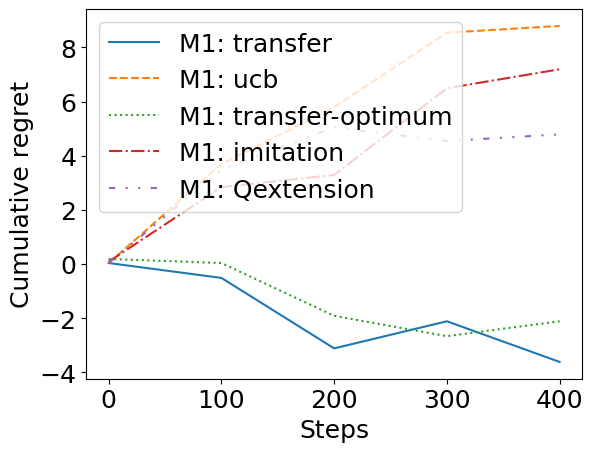

In [26]:
style = ['-','--',':','-.',linestyles['dashdotdotted']]
for n,i in enumerate([0,2,3,4,5]):
    cumregrets = [agents[i][j].get_cumulative_regret() for j in range(len(agents[i]))]
    avg = np.mean(cumregrets,axis=0)

    plt.plot(np.arange(n_steps)[0::100],avg[0::100],label=labels[i],color="C{}".format(n),linestyle=style[n])
    plt.xlabel('Steps')
    plt.ylabel('Cumulative regret')
    plt.legend()

### Plot data persistence 

In [24]:
avgcumregrets = []
for i in [0,1,2,3,4,5]:
    cumregrets = np.array([agents[i][j].get_cumulative_regret() for j in range(n_trials)])
    avgcumregrets.append(np.mean(cumregrets,axis=0))
joblib.dump(avgcumregrets,'proj CARLa 3_0/results/simul_4_2a_avgcumregrets.pkl')

['proj CARLa 3_0/results/simul_4_2a_avgcumregrets.pkl']

In [27]:
agents[0][1].bounds

[[0.72], [0.82]]

In [28]:
agents[5][2].bounds

[[-0.1128828047799787, 0.23187773211492346],
 [1.2291618745474202, 1.1918510814443974]]

In [30]:
agents[5][1].env.expct_rewards

[0.5800000000000001, 0.7400000000000001]